In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

from bs4 import BeautifulSoup
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import seaborn as sns
from tqdm import tqdm
import os

    

In [2]:
data=pd.read_csv('Reviews.csv')

In [3]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [5]:
data.shape

(568454, 10)

In [6]:
dup = data[data.duplicated(subset=['UserId','ProfileName','Time','Text'],keep=False)]

In [7]:
dup.shape

(232415, 10)

In [8]:
df = data.drop_duplicates(subset=['UserId','ProfileName','Time','Text'],keep='first',inplace=False)
df.shape

(393933, 10)

In [9]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [10]:
df = df[df['HelpfulnessNumerator'] <= df['HelpfulnessDenominator']]

In [11]:
df.shape

(393931, 10)

In [12]:
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase


stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])



preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(df['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    # removing html tags
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    # removing extra spaces and numbers
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    # removing non alphabels
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 393931/393931 [02:09<00:00, 3048.95it/s]


In [13]:
df['clean_text'] = preprocessed_reviews

In [14]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,clean_text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,bought several vitality canned dog food produc...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled jumbo salted peanuts p...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,confection around centuries light pillowy citr...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,looking secret ingredient robitussin believe f...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffy great price wide assortment yummy ...


In [15]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [16]:
vs= SentimentIntensityAnalyzer()

In [17]:
df['compound']=df['Text'].apply( lambda x: vs.polarity_scores(x)['compound'])

In [18]:
# df['compound_clean']=df['clean_text'].apply( lambda x: vs.polarity_scores(x)['compound'])

In [19]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,clean_text,compound
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,bought several vitality canned dog food produc...,0.9441
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled jumbo salted peanuts p...,-0.5664
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,confection around centuries light pillowy citr...,0.8138
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,looking secret ingredient robitussin believe f...,0.4404
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,great taffy great price wide assortment yummy ...,0.9468


In [20]:
# score_1 = df['compound_clean'].apply(lambda x: 1 if x > 0 else 0)

# # score = df['Score'].apply(lambda x: 1 if x > 3 else 0)
# # df['Score'] = score
# # df.head(3)

# df['sentiment_1'] = score_1
# df.head(3)

In [21]:
score = df['compound'].apply(lambda x: 1 if x > 0 else 0)

# score = df['Score'].apply(lambda x: 1 if x > 3 else 0)
# df['Score'] = score
# df.head(3)

df['sentiment'] = score
df.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,clean_text,compound,sentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,bought several vitality canned dog food produc...,0.9441,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled jumbo salted peanuts p...,-0.5664,0
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,confection around centuries light pillowy citr...,0.8138,1


In [65]:
df[df['compound']<0.2]

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,clean_text,compound,sentiment
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,product arrived labeled jumbo salted peanuts p...,-0.5664,0
11,12,B0009XLVG0,A2725IB4YY9JEB,"A Poeng ""SparkyGoHome""",4,4,5,1282867200,"My cats LOVE this ""diet"" food better than thei...",One of my boys needed to lose some weight and ...,one boys needed lose weight not put food floor...,-0.7579,0
25,26,B001GVISJM,A3FONPR03H3PJS,"Deborah S. Linzer ""Cat Lady""",0,0,5,1288310400,Twizzlers - Strawberry,Product received is as advertised.<br /><br />...,product received advertised,0.0000,0
26,27,B001GVISJM,A3RXAU2N8KV45G,lady21,0,1,1,1332633600,Nasty No flavor,"The candy is just red , No flavor . Just plan...",candy red no flavor plan chewy would never buy,-0.2960,0
45,46,B001EO5QW8,A39Z97950MCTQE,K. A. Freel,0,0,3,1205193600,Hearty Oatmeal,This seems a little more wholesome than some o...,seems little wholesome supermarket brands some...,0.0000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
568431,568432,B003XUL27E,A32Y0419QFGVHM,Kevin Mitchell,0,0,1,1319673600,Mostly water,Definitely not worth buying flavored water wit...,definitely not worth buying flavored water tea...,0.1818,1
568434,568435,B003XUL27E,ABGQPE97ZVYJ3,Katherine Kelly,0,0,2,1306368000,Not so good,This soup is mostly broth. Although it has a k...,soup mostly broth although kick also sweet tas...,-0.2311,0
568446,568447,B001EO7N10,A2P9W8T7NTLG2Z,Andy,0,0,2,1328918400,Mixed wrong,I had ordered some of these a few months back ...,ordered months back great latest batch terribl...,0.1655,1
568448,568449,B001EO7N10,A1F6BHEYB7R6R7,James Braley,0,0,5,1308096000,Very large ground spice jars.,My only complaint is that there's so much of i...,complaint much not use huge amount spice gave ...,-0.0675,0


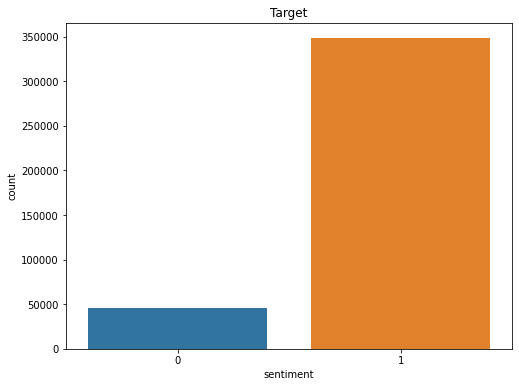

In [22]:
plt.figure(figsize=(8,6))
sns.countplot(df['sentiment'])
plt.title('Target')
plt.show()

In [23]:
df['sentiment'].value_counts()

1    348148
0     45783
Name: sentiment, dtype: int64

In [24]:
# df['sentiment_1'].value_counts()

In [25]:
from wordcloud import WordCloud

In [26]:
def create_wordcloud(words):
    wordcloud=WordCloud(width=800,height=600,random_state=42).generate(words)
    plt.figure(figsize=(10,7))
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.axis('off')

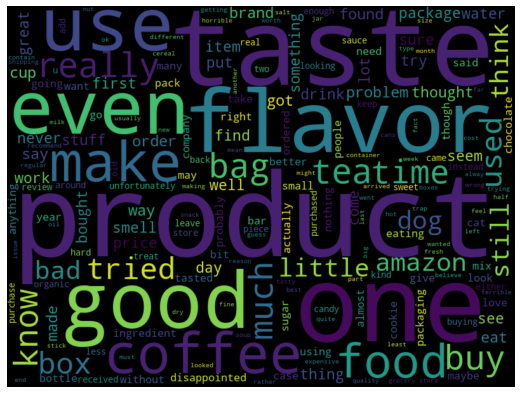

In [27]:
subset=df[df.sentiment==0]
text=subset.clean_text.values
words=''.join(text)
create_wordcloud(words)

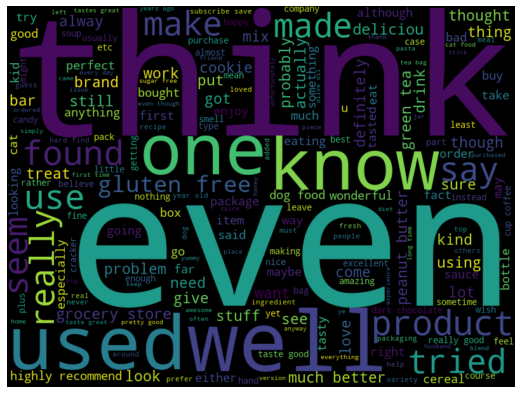

In [28]:
subset=df[df.sentiment==1]
text=subset.clean_text.values
words=''.join(text)
create_wordcloud(words)

In [29]:
p_df = df[['clean_text','sentiment']]
#reseting index
p_df = p_df.reset_index(drop=True)
#saving processed file
#df.to_csv('processed_df.csv',index=False)

In [30]:
p_df.shape

(393931, 2)

In [31]:
p_df.head()

,clean_text,sentiment
0,bought several vitality canned dog food produc...,1
1,product arrived labeled jumbo salted peanuts p...,0
2,confection around centuries light pillowy citr...,1
3,looking secret ingredient robitussin believe f...,1
4,great taffy great price wide assortment yummy ...,1


In [32]:
p_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393931 entries, 0 to 393930
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   clean_text  393931 non-null  object
 1   sentiment   393931 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 6.0+ MB


In [33]:
p_df = p_df.dropna(axis=0)
p_df.shape

(393931, 2)

In [34]:
# p_df = p_df.sample(100000,random_state=100)

In [35]:
#splitting data to train.cv and test
from sklearn.model_selection import train_test_split
x = p_df['clean_text']
y = p_df['sentiment']
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.2,stratify=y,random_state=100)
# X_tr,X_cv,y_tr,y_cv = train_test_split(X_train,y_train,test_size=0.3,stratify=y_train,random_state=100)
print(f'shape of X_train is {X_train.shape}')
print(f'shape of X_test is {X_test.shape}')
print(f'shape of y_train is {y_train.shape}')
print(f'shape of y_test is {y_test.shape}')

shape of X_train is (315144,)
shape of X_test is (78787,)
shape of y_train is (315144,)
shape of y_test is (78787,)


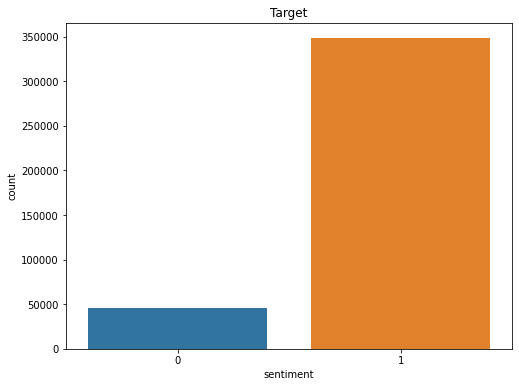

In [36]:
plt.figure(figsize=(8,6))
sns.countplot(p_df['sentiment'])
plt.title('Target')
plt.show()

In [37]:
#Tfidf

In [38]:
ngram_range=(1,2)
max_features=2000

In [39]:
#applying bow on x_train and x_test
tfidf=TfidfVectorizer(encoding='utf-8',
                      ngram_range=ngram_range,
                      stop_words=None,
                      lowercase=False,
                      max_features=max_features,
                      norm='l2',
                      sublinear_tf=True
                     )
tfidf.fit(X_train)
tfidf_features = tfidf.get_feature_names()
# we use the fitted CountVectorizer to convert the text to vector
X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [58]:
import pickle
with open('tfidf_rev.pickle','wb') as f:
    pickle.dump(tfidf,f)

### Model Building

In [43]:
# helper function to plot confusion matrix
def plot_confusion_matrixes(model,x_train,y_train,x_test,y_test):
    cm_train = confusion_matrix(y_train,model.predict(x_train))
    cm_test =  confusion_matrix(y_test,model.predict(x_test))
    class_label = ["negative", "positive"]
    df_train = pd.DataFrame(cm_train, index = class_label, columns = class_label)
    df_test = pd.DataFrame(cm_test, index = class_label, columns = class_label)
    f, axes = plt.subplots(1, 2,figsize=(12,4))

    for i in range(2):
      df = df_train if i==0 else df_test
      sns.heatmap(df, annot = True, fmt = "d",ax=axes[i])
      axes[i].set_title(f"Confusion Matrix - {'Train' if i==0 else 'Test'}")
      axes[i].set_xlabel("Predicted Label")
      axes[i].set_ylabel("True Label")
    plt.show()

## MultinomialNB

In [44]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score , accuracy_score , classification_report


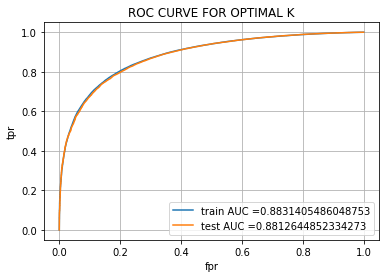

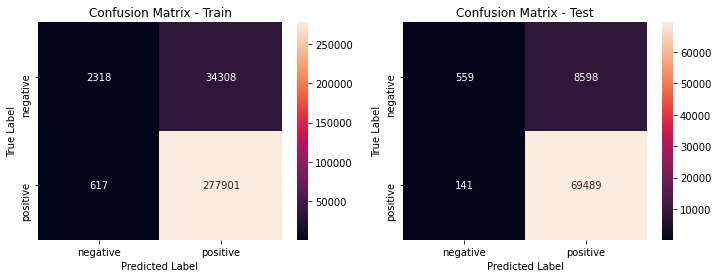

Area under train roc 0.8831405486048753
Area under test roc 0.8812644852334273


In [45]:
from sklearn.metrics import roc_curve, auc
optimal_alpha = 0.1
naive_opt = MultinomialNB(alpha=optimal_alpha)
naive_opt = naive_opt.fit(X_train_tfidf,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, naive_opt.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, naive_opt.predict_proba(X_test_tfidf)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

plot_confusion_matrixes(naive_opt,X_train_tfidf,y_train,X_test_tfidf,y_test)


#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))


## LogisticRegression

In [46]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

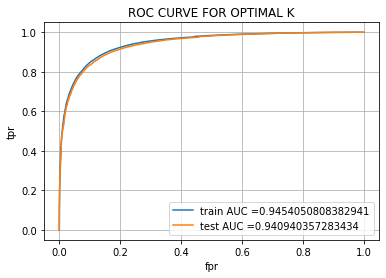

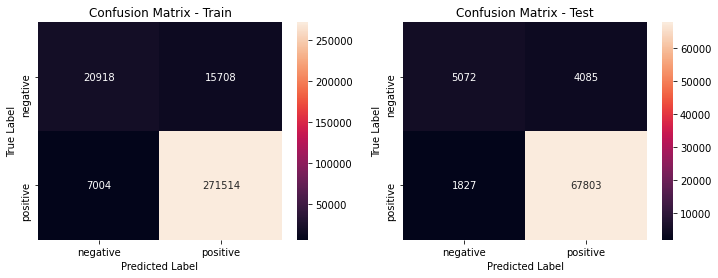

Area under train roc 0.9454050808382941
Area under test roc 0.940940357283434


In [47]:
clf_l1_opt = LogisticRegression(C=10.0,solver='liblinear')
clf_l1_opt = clf_l1_opt.fit(X_train_tfidf,y_train)
train_fpr, train_tpr, thresholds = roc_curve(y_train, clf_l1_opt.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, clf_l1_opt.predict_proba(X_test_tfidf)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()


plot_confusion_matrixes(clf_l1_opt,X_train_tfidf,y_train,X_test_tfidf,y_test)

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))

In [59]:
import pickle
with open('lg_review_1.pickle','wb') as f:
    pickle.dump(clf_l1_opt,f)

In [49]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# from keras.preprocessing import sequence

Using TensorFlow backend.


In [60]:
# lg_model=pickle.load(open('C:/Users/sarat/DF 2009/portfolio/lg_review_1.pickle','rb'))

In [51]:
# embedded_docs = sequence.pad_sequences(vect_form, padding='pre', maxlen=108984)

In [61]:
vectorizer_3=pickle.load(open('C:/Users/sarat/DF 2009/portfolio/tfidf_rev.pickle','rb'))

In [53]:
#vectorizer_1=TfidfVectorizer(max_features=max_features,norm='l2')

In [54]:
# vectorizer_2=TfidfVectorizer()

In [63]:
# new_reviews = [ "If you are looking for the secret ingredient in Robitussin I believe I have found it.  I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda.  The flavor is very medicinal.",
#                  "One of my boys needed to lose some weight and the other didn't.  I put this food on the floor for the chubby guy, and the protein-rich, no by-product food up higher where only my skinny boy can jump.  The higher food sits going stale.  They both really go for this food.  And my chubby boy has been losing about an ounce a week."]
# vect_form = vectorizer_3.transform(new_reviews).toarray()

# s=lg_model.predict_proba(vect_form)
# print(s) #Politics:0, Technology: 1

[[0.09365349 0.90634651]
 [0.70009424 0.29990576]]


## RandomForestClassifier

In [56]:
from sklearn.ensemble import RandomForestClassifier

# 'max_depth': 25, 'n_estimators': 120

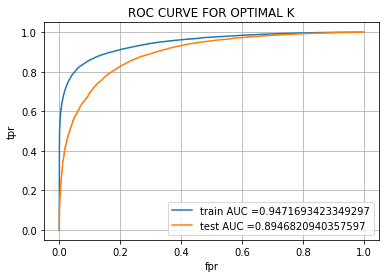

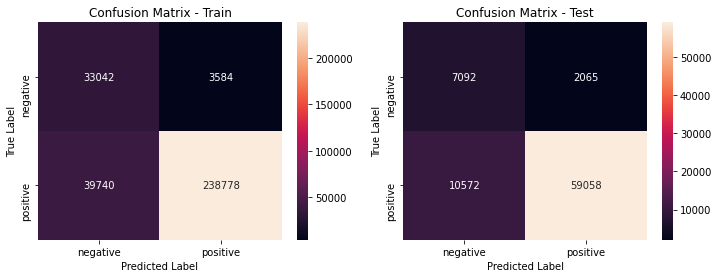

Area under train roc 0.9471693423349297
Area under test roc 0.8946820940357597


In [57]:
best_est = RandomForestClassifier(n_estimators= 120,max_depth=25,class_weight='balanced')
best_est = best_est.fit(X_train_tfidf,y_train)

train_fpr, train_tpr, thresholds = roc_curve(y_train, best_est.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_est.predict_proba(X_test_tfidf)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()


plot_confusion_matrixes(best_est,X_train_tfidf,y_train,X_test_tfidf,y_test)

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))